# GDSII import

<img src="img/splitter.png" alt="diagram" width="400"/>

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FGDS_import.ipynb).

In Tidy3D, complex structures can be defined or imported from GDSII files via the third-party [gdspy](https://gdspy.readthedocs.io/en/stable/index.html) package. In this tutorial, we will first illustrate how to use the package to define a structure, then we will save this to file, and then we will read that file and import the structures in a simulation.

Note that this tutorial requires gdspy, so grab it with `pip install gdspy` before running the tutorial or uncomment the cell line below.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdspy
import os

# tidy3d import
import tidy3d as td
from tidy3d import web

[15:34:48] INFO     Using client version: 1.8.0                               ]8;id=515820;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=66474;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#107\107]8;;\

## Creating a beam splitter with gdspy

First, we will construct an integrated beam splitter as in the title image in this notebook using `gdspy`. If you are only interested in importing an already existing GDSII file, just jump ahead to the next section.

We first define some structural parameters. We consider the sidewall of the device to be slanted, deviating from the vertical sidewall by `sidewall_angle`. `sidewall_angle>0` corresponds to a typical fabrication scenario where the base of the device is larger than the top.

We define the device by constructing the cross section of the device. The cross section can be supplied at the `top`, `bottom`, or the `middle` of the device, specified by the parameter `reference_plane`. Here we choose to define the cross section on the base. On the base, the two arms of the device start at a distance `wg_spacing_in` apart, then come together at a coupling distance `wg_spacing_coup` for a certain length `coup_length`, and then split again into separate ports. In the coupling region, the field overlap results in energy exchange between the two waveguides. Here, we will only see how to define, export, and import such a device using `gdspy`. When importing the device, we can optionally dilate or erode its cross section via `dilation`. In a later example we will simulate the device and study the frequency dependence of the transmission into each of the ports.

In [2]:
### Length scale in micron.

# Waveguide width
wg_width = 0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# Length of the coupling region
coup_length = 10
# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi/6
# Reference plane where the cross section of the device is defined
reference_plane = "bottom"
# Length of the bend region
bend_length = 16
# Waveguide separation in the coupling region
wg_spacing_coup = 0.10
# Total device length along propagation direction
device_length = 100

### Generating Geometry
To create the device, we will define each waveguide as a GDSII path object with the given waveguide width. To do that, we just need to define a series of points along the base of each waveguide that follows the curvature we desire. First, we define a convenience function to create the points along one of the waveguides, using a hyperbolic tangent curvature between the input and coupling regions. The second waveguide is just a reflected version of the first one.

<Figure size 576x216 with 1 Axes>

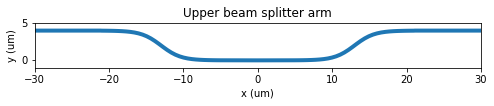

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    ### Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

# Plot the upper arm for the current configuration
arm_center_coords = arm_pts(
    device_length,
    wg_spacing_in/2,
    coup_length,
    bend_length)

fig, ax = plt.subplots(1, figsize=(8, 3))
ax.plot(arm_center_coords[:, 0], arm_center_coords[:, 1], lw=4)
ax.set_xlim([-30, 30])
ax.set_ylim([-1, 5])
ax.set_xlabel("x (um)")
ax.set_ylabel("y (um)")
ax.set_title("Upper beam splitter arm")
ax.axes.set_aspect('equal')
plt.show()

We can take the `arm_pts` function defined above and use it to define a FlexPath to create a curved waveguide.

We put this in a convenience function defined below.

In [4]:
def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)

    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2

    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Writing to GDS cells

Next, we construct the splitter and write it to a GDS cell. We add a rectangle for the substrate to layer 0, and in layer 1 we add two paths, one for the upper and one for the lower splitter arms, and set the path width to be the waveguide width defined above.

In [5]:
# make gds library
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Create a gds cell to add our structures to
coup_cell = lib.new_cell('Coupler')

# make substrate and add to cell
substrate = gdspy.Rectangle(
    (-device_length/2, -wg_spacing_in/2-10),
    (device_length/2, wg_spacing_in/2+10),
    layer=0)

coup_cell.add(substrate)

# make coupler and add to the gdspy cell
top, bot = make_coupler(
    device_length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length)

coup_cell.add(top)
coup_cell.add(bot)

<gdspy.library.Cell object at 0x7feec47821c0>

### Writing to GDS file
To write the gds cell to file is straightforward.

First we will clear the file if it exists and write to it using gdspy.

In [6]:
gds_path = 'data/coupler.gds'

if os.path.exists(gds_path):
    os.remove(gds_path)

lib.write_gds(gds_path)

## Loading a GDS file into Tidy3d

We first load the file we just created into a gdspy library and grab the "Coupler" cell containing our structures.

In [7]:
lib_loaded = gdspy.GdsLibrary(infile=gds_path)
coup_cell_loaded = lib_loaded.cells['Coupler']

### Set up Geometries

Then we can construct tidy3d "PolySlab" geometries from the GDS cell we just loaded, along with other information such as the axis, sidewall angle, and bounds of the "slab". When loading GDS cell as the cross section of the device, we can tune ``reference_plane`` to set the cross section to lie at ``bottom``, ``middle``, or ``top`` of the "PolySlab" with respect to the axis. E.g. if ``axis=1``, ``bottom`` refers to the negative side of the y-axis, and ``top`` refers to the positive side of the y-axis. Additionally, we can optionally dilate or erode the cross section by setting `dilation`. A negative `dilation` corresponds to erosion.

Note, we have to keep track of the `gds_layer` and `gds_dtype` used to defined the GDS cell earlier, so we can load the right components..

In [8]:
# Define waveguide height
wg_height = 0.22
dilation = 0.02

[substrate_geo] = td.PolySlab.from_gds(coup_cell_loaded, gds_layer=0, gds_dtype=0, axis=2, slab_bounds=(-430, 0), reference_plane=reference_plane)
top_arm_geo, bot_arm_geo = td.PolySlab.from_gds(coup_cell_loaded, gds_layer=1, axis=2, slab_bounds=(0, wg_height), sidewall_angle=sidewall_angle, dilation=dilation, reference_plane=reference_plane)


Note that we can also individually select the dtype by supplying `gds_dtype` to `PolySlab.from_gds`.

In [9]:
top_arm_geo = td.PolySlab.from_gds(coup_cell_loaded, gds_layer=1, gds_dtype=0, axis=2, slab_bounds=(0, wg_height), sidewall_angle=sidewall_angle, dilation=dilation, reference_plane=reference_plane)[0]
bot_arm_geo = td.PolySlab.from_gds(coup_cell_loaded, gds_layer=1, gds_dtype=1, axis=2, slab_bounds=(0, wg_height), sidewall_angle=sidewall_angle, dilation=dilation, reference_plane=reference_plane)[0]

Let's plot the base and the top of the coupler waveguide arms to make sure it looks ok. The base of the device should be larger than the top due to a positive `sidewall_angle`.

<Figure size 1080x432 with 2 Axes>

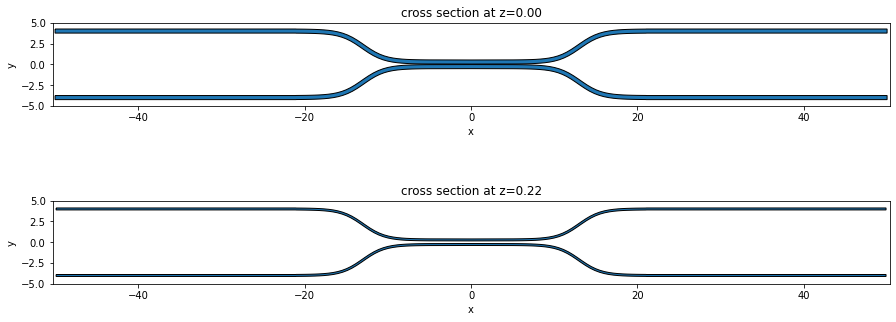

In [10]:
f, ax = plt.subplots(2,1,figsize=(15, 6))
top_arm_geo.plot(z=0., ax=ax[0])
bot_arm_geo.plot(z=0., ax=ax[0])
ax[0].set_ylim(-5, 5)

top_arm_geo.plot(z=wg_height, ax=ax[1])
bot_arm_geo.plot(z=wg_height, ax=ax[1])
ax[1].set_ylim(-5, 5)
plt.show()

### Set up Structures

To make use of these new geometries, we need to load them into a tidy3d.Simulation as td.Structures with material properties.

We'll define the substrate and waveguide mediums and then link them up with the Polyslabs.

In [11]:
# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
medium_wg = td.Medium(permittivity=wg_n**2)
medium_sub = td.Medium(permittivity=sub_n**2)

# Substrate
substrate = td.Structure(
    geometry=substrate_geo,#td.Box(center=(0, 0, -td.inf/2), size=(td.inf, td.inf, td.inf)),
    medium=medium_sub
)

# Waveguides (import all datatypes if gds_dtype not specified)
top_arm = td.Structure(
    geometry=top_arm_geo,
    medium=medium_wg
)

bot_arm = td.Structure(
    geometry=bot_arm_geo,
    medium=medium_wg
)

structures = [substrate, top_arm, bot_arm]

### Set up Simulation

Now let's set up the rest of the Simulation.

In [12]:
# Simulation size along propagation direction
sim_length = 2 + 2*bend_length + coup_length

# Spacing between waveguides and PML
pml_spacing = 1
sim_size = (
    np.ceil(sim_length),
    np.ceil(wg_spacing_in + wg_width + 2*pml_spacing),
    np.ceil(wg_height + 2*pml_spacing)
)

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    grid_spec = td.GridSpec.uniform(dl=dl),
    structures=structures,
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
)

           WARNING  No sources in simulation.                               ]8;id=979452;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=800136;file:///home/weiliang/Documents/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#399\399]8;;\

### Plot Simulation Geometry

Let's take a look at the simulation all together with the PolySlabs added. Here the angle of the sidewall deviating from the vertical direction is 30 degree.

<Figure size 1224x360 with 2 Axes>

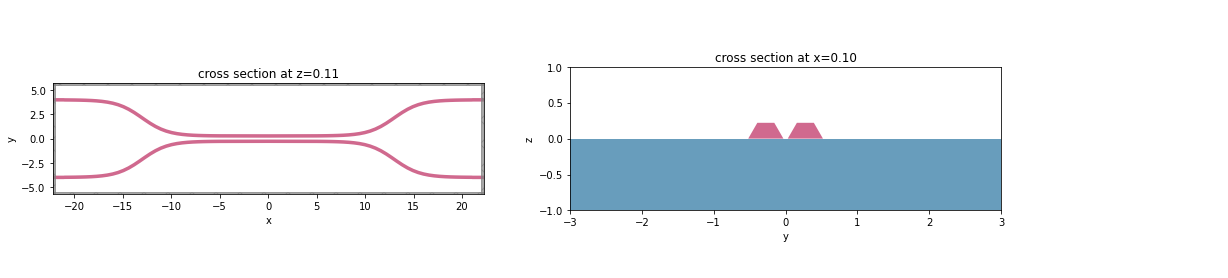

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=wg_height/2, lw=1, edgecolor='k', ax=ax1)
sim.plot(x=0.1, lw=1, edgecolor='k', ax=ax2)

ax2.set_xlim([-3, 3])
ax2.set_ylim([-1, 1])
plt.show()